In [1]:
# parameters
TICKER = globals().get("TICKER", "AAPL")
LOOKBACK = globals().get("LOOKBACK", 90)
HORIZON = globals().get("HORIZON", 10)
OUTPUT_JSON = "forecast.json"


# 10‑Day Forecast Notebook (Returns → Price Reconstruction)

This notebook:
- Predicts **next 10 daily log returns** (HORIZON=10) and reconstructs price paths.
- Uses **StandardScaler** for X and y (returns), leakage‑safe chronological split.
- Adds lags/volatility features + RSI/MACD/Bands.
- Model: **Conv1D + BiLSTM + LSTM** with **Huber + sign-consistency** loss.
- Evaluates on a **held‑out test set** and compares to a naive baseline (flat price).
- Then retrains on **train+val** and produces a **next‑10‑day forecast** from the latest data.


In [2]:
# %pip install -U pandas-market-calendars 

In [3]:

# --- Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# Params
TICKER = globals().get("TICKER", "MUSA")   # change if needed)
START = globals().get("START", "2016-01-01")
END = globals().get("END", None)
INTERVAL = globals().get("INTERVAL", "1d")

LOOKBACK = globals().get("LOOKBACK", 90)
HORIZON = globals().get("HORIZON", 10)          # << we forecast 10 days)
EPOCHS = globals().get("EPOCHS", 200)
BATCH = globals().get("BATCH", 32)

plt.rcParams['figure.figsize'] = (10,4)

try:
    import pandas_market_calendars as mcal
    HAS_PMC = True
except Exception:
    HAS_PMC = False

# Map Yahoo suffixes to exchange calendars (extend if needed)
SUFFIX_TO_CAL = {
    ".L":  "XLON",  # London
    ".TO": "XTSE",  # Toronto
    ".HK": "XHKG",  # Hong Kong
    ".AX": "XASX",  # Australia
    ".NS": "XNSE",  # India (NSE)
    ".BO": "XBOM",  # India (BSE)
    ".SI": "XSES",  # Singapore
    ".SS": "XSHG",  # Shanghai
    ".SZ": "XSHE",  # Shenzhen
}
US_DEFAULT_CAL = "XNYS"  # default NYSE for US tickers

def _guess_exchange(tkr: str) -> str:
    t = tkr.upper()
    for suf, cal in SUFFIX_TO_CAL.items():
        if t.endswith(suf):
            return cal
    # plain alphabetic tickers → assume US (override with exchange="XNAS" for Nasdaq if you prefer)
    return US_DEFAULT_CAL

def _is_crypto_like(tkr: str, recent_idx: pd.DatetimeIndex) -> bool:
    t = tkr.upper()
    # crypto pairs like BTC-USD, ETH-USD, etc., and weekend bars in recent data
    return ("-" in t and t.split("-")[-1] in {"USD","USDT","EUR","BTC","ETH"}
            ) or (pd.Series(recent_idx[-14:]).dt.weekday >= 5).any()

def forecast_index_for(ticker: str, horizon: int = 10, exchange: str | None = None) -> pd.DatetimeIndex:
    """Return the next `horizon` timestamps appropriate for the instrument.
    - Crypto: calendar days (7-day market)
    - Stocks/ETFs: business days; if pandas-market-calendars is available, use exchange holidays.
    """
    hist = yf.download(ticker, period="60d", interval="1d", auto_adjust=True, progress=False)
    if hist.empty:
        raise ValueError(f"No data for {ticker}")
    idx = pd.DatetimeIndex(hist.index).tz_localize(None)
    last_dt = idx[-1]

    # Crypto / 7-day markets → calendar days
    if _is_crypto_like(ticker, idx):
        return pd.date_range(last_dt + pd.Timedelta(days=1), periods=horizon, freq="D")

    # Equities → holiday-aware business days if possible
    cal_code = exchange or _guess_exchange(ticker)
    if HAS_PMC and cal_code:
        cal = mcal.get_calendar(cal_code)
        start = last_dt + pd.Timedelta(days=1)
        valid = cal.valid_days(start_date=start, end_date=start + pd.Timedelta(days=90))
        return pd.DatetimeIndex(valid.tz_localize(None)[:horizon])

    # Fallback: Mon–Fri (no holidays)
    return pd.bdate_range(start=last_dt, periods=horizon+1)[1:]


In [4]:

# --- Data download & feature engineering
def fetch_prices(ticker: str, start="2016-01-01", end=None, interval="1d") -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=True, progress=False)
    if df.empty:
        raise ValueError("No data returned. Check ticker/interval or your network.")
    df.index.name = "Date"
    return df[["Open","High","Low","Close","Volume"]].dropna()

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    close = pd.to_numeric(out["Close"].squeeze(), errors="coerce")
    close = close.where(close>0, np.nan)
    out["Close"] = close

    # base returns
    out["log_ret"] = np.log(close).diff()
    out["ret"]     = close.pct_change()

    # rolling stats
    out["roll_mean_7"]  = close.rolling(7).mean()
    out["roll_std_7"]   = close.rolling(7).std()
    out["roll_mean_21"] = close.rolling(21).mean()
    out["roll_std_21"]  = close.rolling(21).std()

    # RSI(14)
    delta = close.diff()
    up    = delta.clip(lower=0)
    down  = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
    roll_dn = down.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
    rs = roll_up / roll_dn.replace(0, np.nan)
    out["rsi_14"] = 100 - (100/(1+rs))

    # MACD (12,26,9)
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    out["macd"]        = macd
    out["macd_signal"] = macd.ewm(span=9, adjust=False).mean()
    out["macd_diff"]   = out["macd"] - out["macd_signal"]

    # Bollinger width (20,2)
    ma20 = close.rolling(20).mean()
    sd20 = close.rolling(20).std()
    out["bb_width"] = (ma20 + 2*sd20 - (ma20 - 2*sd20)) / close

    # lags & volatility
    out["ret_lag1"] = out["log_ret"].shift(1)
    out["ret_lag3"] = out["log_ret"].shift(3)
    out["ret_lag5"] = out["log_ret"].shift(5)
    out["vol_7"]    = out["log_ret"].rolling(7).std()
    out["vol_21"]   = out["log_ret"].rolling(21).std()
    out["z_close_21"] = (close - close.rolling(21).mean()) / close.rolling(21).std()

    return out.dropna()

raw = fetch_prices(TICKER, start=START, end=END, interval=INTERVAL)
df  = add_features(raw)

# Target = next-step log return
df["target_ret"] = df["log_ret"].shift(-1)
df = df.dropna()

FEATURES = [
    "Close","Volume","log_ret","ret",
    "roll_mean_7","roll_std_7","roll_mean_21","roll_std_21",
    "rsi_14","macd","macd_signal","macd_diff","bb_width",
    "ret_lag1","ret_lag3","ret_lag5","vol_7","vol_21","z_close_21"
]

target = df["target_ret"].astype("float32").values
X_df   = df[FEATURES].astype("float32")
df.tail(2)


Price,Open,High,Low,Close,Volume,log_ret,ret,roll_mean_7,roll_std_7,roll_mean_21,...,macd_signal,macd_diff,bb_width,ret_lag1,ret_lag3,ret_lag5,vol_7,vol_21,z_close_21,target_ret
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2025-08-13,231.070007,235.000000,230.429993,233.330002,69878500,0.015897,0.016024,222.104111,10.973994,214.242249,...,2.792759,2.434222,0.154725,0.010814,0.041485,0.049653,0.021847,0.017612,2.156198,-0.002360
2025-08-14,234.059998,235.119995,230.850006,232.779999,51916300,-0.002360,-0.002357,226.402688,7.419479,215.330736,...,3.407697,2.459753,0.168876,0.015897,-0.008372,0.031299,0.021888,0.017691,1.805797,-0.005125


In [5]:

# --- Split, scale, windowing
def chronological_split(X_df: pd.DataFrame, y: np.ndarray, train_ratio=0.7, val_ratio=0.15):
    n = len(X_df)
    tr_end = int(train_ratio*n)
    va_end = int((train_ratio+val_ratio)*n)
    return (X_df.iloc[:tr_end], X_df.iloc[tr_end:va_end], X_df.iloc[va_end:]), (y[:tr_end], y[tr_end:va_end], y[va_end:])

(X_tr_df, X_va_df, X_te_df), (y_train, y_val, y_test) = chronological_split(X_df, target, 0.7, 0.15)

# Clip extremes (winsorize) on train distribution
lo, hi = np.nanpercentile(y_train, [1, 99])
_clip = lambda a: np.clip(a, lo, hi)
y_train, y_val, y_test = _clip(y_train), _clip(y_val), _clip(y_test)

# Scale X & y on TRAIN only
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_tr_df.values)
X_val   = scaler_X.transform(X_va_df.values)
X_test  = scaler_X.transform(X_te_df.values)

scaler_y = StandardScaler()
y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()
y_val_s   = scaler_y.transform(y_val.reshape(-1,1)).ravel()
y_test_s  = scaler_y.transform(y_test.reshape(-1,1)).ravel()

def make_windows(X, y, lookback, horizon):
    X = np.asarray(X); y = np.asarray(y)
    xs, ys = [], []
    for i in range(lookback, len(X)-horizon+1):
        xs.append(X[i-lookback:i, :])
        ys.append(y[i:i+horizon])
    return np.array(xs, dtype="float32"), np.array(ys, dtype="float32")

X_tr_w, y_tr_w = make_windows(X_train, y_train_s, LOOKBACK, HORIZON)
X_va_w, y_va_w = make_windows(X_val,   y_val_s,   LOOKBACK, HORIZON)
X_te_w, y_te_w = make_windows(X_test,  y_test_s,  LOOKBACK, HORIZON)

X_tr_w.shape, y_tr_w.shape, X_va_w.shape, y_va_w.shape, X_te_w.shape, y_te_w.shape

((1608, 60, 19),
 (1608, 10),
 (291, 60, 19),
 (291, 10),
 (291, 60, 19),
 (291, 10))

In [6]:

# --- Model
def build_model(input_steps, n_features, horizon):
    inp = tf.keras.Input(shape=(input_steps, n_features))
    x = tf.keras.layers.Conv1D(48, kernel_size=5, padding="causal", activation="relu")(inp)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.LSTM(96)(x)
    out = tf.keras.layers.Dense(horizon)(x)
    model = tf.keras.Model(inp, out)

    # element-wise Huber + sign consistency (both => [batch, horizon])
    def huber_with_sign(y_true, y_pred, delta=1.0):
        err = y_true - y_pred
        abs_err = tf.abs(err)
        quadratic = tf.minimum(abs_err, delta)
        linear = abs_err - quadratic
        base = 0.5 * tf.square(quadratic) + delta * linear          # [B, H]
        sign_pen = tf.nn.softplus(-5.0 * y_true * y_pred)           # [B, H]
        loss_per_step = base + 0.1 * sign_pen                       # [B, H]
        return tf.reduce_mean(loss_per_step, axis=-1)               # [B]

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=huber_with_sign)
    return model


model = build_model(LOOKBACK, X_tr_w.shape[2], HORIZON)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 19)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 48)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 320)        │       267,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 320)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │       160,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,226 (1.65 MB)

 Trainable params: 433,226 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:

# --- Train with early stopping
cbs = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-5),
]
hist = model.fit(X_tr_w, y_tr_w, validation_data=(X_va_w, y_va_w),
                 epochs=EPOCHS, batch_size=BATCH, callbacks=cbs, verbose=1)
pd.DataFrame(hist.history).tail()


Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.4735 - val_loss: 0.3157 - learning_rate: 0.0010
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4629 - val_loss: 0.3144 - learning_rate: 0.0010
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4593 - val_loss: 0.3206 - learning_rate: 0.0010
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.4558 - val_loss: 0.3188 - learning_rate: 0.0010
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4516 - val_loss: 0.3208 - learning_rate: 0.0010
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4485 - val_loss: 0.3350 - learning_rate: 0.0010
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4446 - val_loss: 0.3296 - learning_rate: 0.0010
Epoch 8/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.4402 - val_loss: 0.3339 - learning_rate: 0.0010
Epoch 9/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.4353 - val_loss: 0.3313 - learning_rate: 0.0010
Epoch 10/2

,loss,val_loss,learning_rate
17,0.394106,0.355139,0.00050
18,0.387317,0.361420,0.00025
19,0.383761,0.362674,0.00025
20,0.379421,0.372947,0.00025
21,0.377033,0.368803,0.00025


Model -> RMSE: 9.69 | MAE: 7.05 | sMAPE: 3.24% | DA_all: 0.476 | DA_h1: 0.526
Naive -> RMSE: 9.67 | MAE: 7.03 | sMAPE: 3.22%


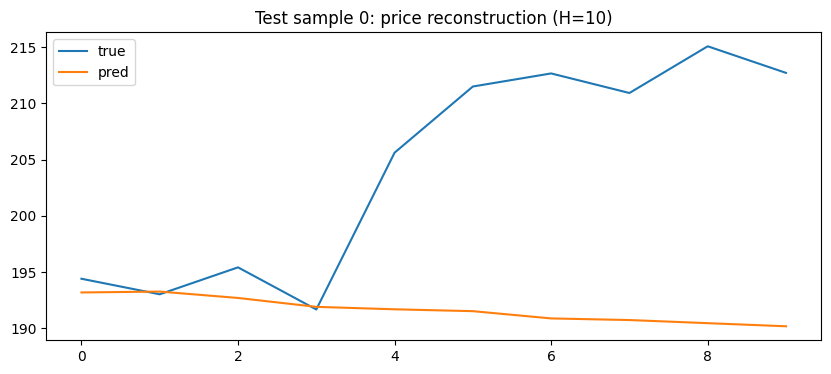

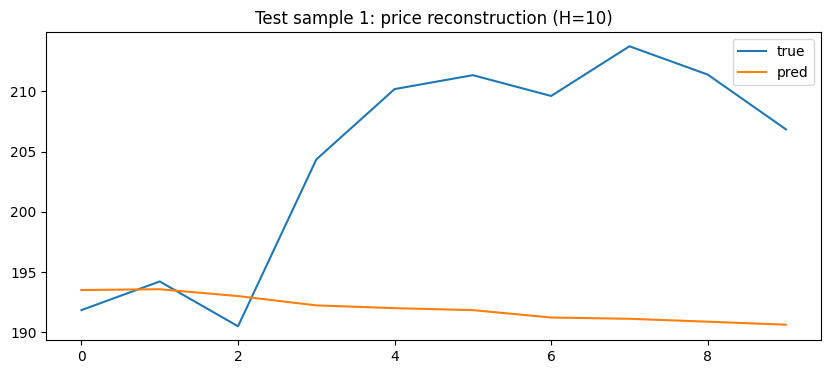

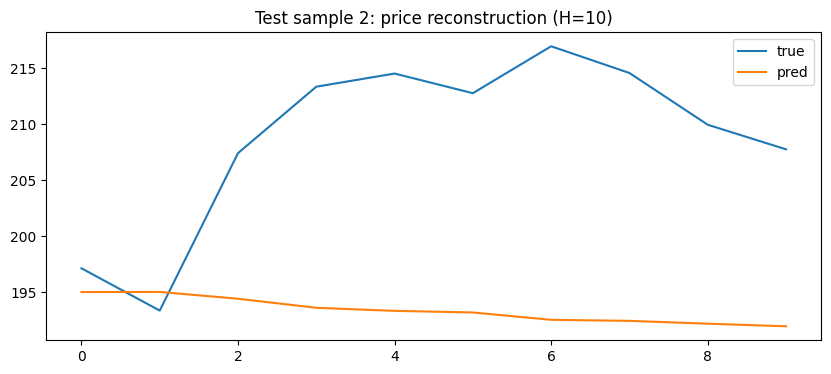

In [8]:

# --- Evaluation (test) — returns -> price reconstruction + metrics
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    return np.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    d = (np.abs(y_true)+np.abs(y_pred))/2.0
    d = np.where(d==0, 1e-8, d)
    return np.mean(np.abs(y_true - y_pred)/d)*100

def returns_to_prices(p0, r):
    r = np.asarray(r).reshape(-1)
    return p0 * np.exp(np.cumsum(r))

# Predict scaled returns -> invert to returns
y_hat_s   = model.predict(X_te_w, verbose=0)
y_hat_ret = scaler_y.inverse_transform(y_hat_s.reshape(-1,1)).ravel().reshape(y_hat_s.shape)

# True returns directly from df + aligned start prices
num = y_hat_ret.shape[0]
test_start = len(X_tr_df) + len(X_va_df)
last_idx   = test_start + (LOOKBACK-1) + np.arange(num)
assert last_idx[-1] < len(df), "Index overflow"

start_prices   = df["Close"].values[last_idx].astype("float32")
true_ret_full  = df["target_ret"].values.astype("float32")

true_ret_list, keep = [], []
for i in range(num):
    s = test_start + LOOKBACK + i
    r = true_ret_full[s:s+HORIZON]
    if len(r)==HORIZON and not np.isnan(r).any():
        true_ret_list.append(r); keep.append(i)
keep = np.array(keep, int)

y_hat_ret    = y_hat_ret[keep]
start_prices = start_prices[keep]
y_true_ret   = np.vstack(true_ret_list)

# Reconstruct prices
pred_prices = np.vstack([returns_to_prices(p0, r) for p0, r in zip(start_prices, y_hat_ret)])
true_prices = np.vstack([returns_to_prices(p0, r) for p0, r in zip(start_prices, y_true_ret)])

# Metrics vs naive (flat price)
naive = np.repeat(start_prices[:,None], HORIZON, axis=1)

y_true_flat, y_pred_flat, naive_flat = true_prices.ravel(), pred_prices.ravel(), naive.ravel()
rmse_v = rmse(y_true_flat, y_pred_flat)
mae_v  = mean_absolute_error(y_true_flat, y_pred_flat)
smp_v  = smape(y_true_flat, y_pred_flat)

rmse_n = rmse(y_true_flat, naive_flat)
mae_n  = mean_absolute_error(y_true_flat, naive_flat)
smp_n  = smape(y_true_flat, naive_flat)

# Directional accuracy in returns space
da_all = (np.sign(y_true_ret) == np.sign(y_hat_ret)).mean()
da_h1  = (np.sign(y_true_ret[:,0]) == np.sign(y_hat_ret[:,0])).mean()

print("Model -> RMSE: %.2f | MAE: %.2f | sMAPE: %.2f%% | DA_all: %.3f | DA_h1: %.3f" % (rmse_v, mae_v, smp_v, da_all, da_h1))
print("Naive -> RMSE: %.2f | MAE: %.2f | sMAPE: %.2f%%" % (rmse_n, mae_n, smp_n))

# Plot a few samples
k = min(3, pred_prices.shape[0])
for i in range(k):
    plt.figure()
    plt.plot(true_prices[i], label="true")
    plt.plot(pred_prices[i], label="pred")
    plt.title(f"Test sample {i}: price reconstruction (H={HORIZON})")
    plt.legend(); plt.show()

Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.4792 - val_loss: 0.2828 - learning_rate: 0.0010
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.4692 - val_loss: 0.2827 - learning_rate: 0.0010
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.4670 - val_loss: 0.2834 - learning_rate: 0.0010
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4647 - val_loss: 0.2890 - learning_rate: 0.0010
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.4617 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.4585 - val_loss: 0.2851 - learning_rate: 0.0010
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4541 - val_loss: 0.2878 - learning_rate: 0.0010
Epoch 8/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4486 - val_loss: 0.2905 - learning_rate: 0.0010
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.4448 - val_loss: 0.2919 - learning_rate: 0.0010
Epoch 10/2

,date,pred_return,pred_price
0,2025-08-18,-0.001883,232.342056
1,2025-08-19,-0.000281,232.276872
2,2025-08-20,0.000656,232.429175
3,2025-08-21,-0.002816,231.775687
4,2025-08-22,-0.002499,231.197123
5,2025-08-25,-0.001303,230.896138
6,2025-08-26,-0.000646,230.746957
7,2025-08-27,0.000181,230.788803
8,2025-08-28,-0.001048,230.547035
9,2025-08-29,-0.000515,230.428420


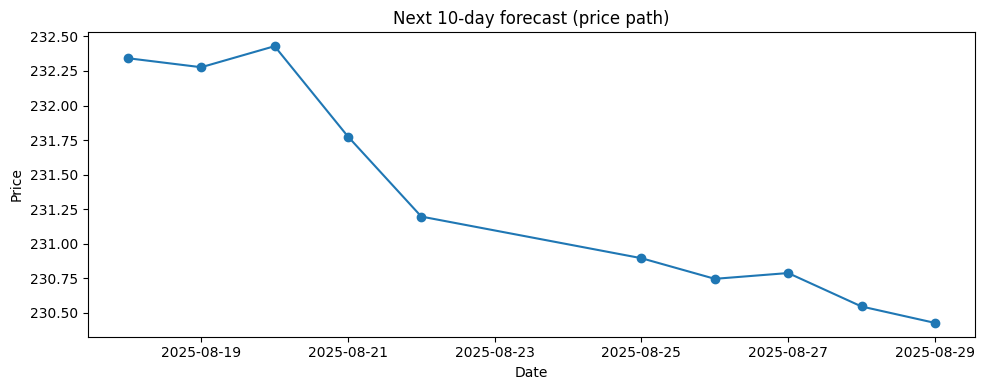

In [9]:
# --- Final next-10-day forecast from latest window
# Retrain on (train+val) for best use of data, then forecast from latest features
X_trv   = np.vstack([X_train, X_val])
y_trv_s = np.concatenate([y_train_s, y_val_s])

X_trv_w, y_trv_w = make_windows(X_trv, y_trv_s, LOOKBACK, HORIZON)
final_model = build_model(LOOKBACK, X_trv_w.shape[2], HORIZON)

final_model.fit(
    X_trv_w, y_trv_w, validation_split=0.1,
    epochs=EPOCHS, batch_size=BATCH, verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-5),
    ],
)

# Latest LOOKBACK block from ALL data
X_all = np.vstack([X_train, X_val, X_test])
last_block = X_all[-LOOKBACK:].reshape(1, LOOKBACK, X_trv_w.shape[2])

next_ret_s = final_model.predict(last_block, verbose=0)[0]
next_ret   = scaler_y.inverse_transform(next_ret_s.reshape(-1,1)).ravel()

last_price  = df["Close"].values[-1]
next_prices = last_price * np.exp(np.cumsum(next_ret))

# ✅ Build future date index (calendar-aware: stocks skip weekends/holidays, crypto is 7-day)
# Requires `forecast_index_for` helper cell from earlier.
future_dates = forecast_index_for(TICKER, horizon=HORIZON)
# (Optionally force an exchange, e.g. Nasdaq)
# future_dates = forecast_index_for(TICKER, horizon=HORIZON, exchange="XNAS")

print(TICKER)
forecast_df = pd.DataFrame({
    "date": future_dates,
    "pred_return": next_ret,
    "pred_price": next_prices
})

display(forecast_df)

plt.figure()
plt.plot(forecast_df["date"], forecast_df["pred_price"], marker="o")
plt.title("Next 10-day forecast (price path)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.tight_layout(); plt.show()

In [10]:

# --- Emit forecast as JSON for the API runner ---
import pandas as pd

# If your notebook already built `forecast_df` with columns: date, pred_return, pred_price, we'll use it.
# Otherwise, try to construct it from common variable names without changing your code.
if 'forecast_df' not in globals():
    # Try to pick up future dates from variables you might have created
    if 'future_dates' in globals():
        _dates = pd.to_datetime(list(future_dates))
    elif 'future_idx' in globals():
        _dates = pd.to_datetime(list(future_idx))
    elif 'dates' in globals():
        _dates = pd.to_datetime(list(dates))
    else:
        # Fallback: create a simple daily index so the API still returns something
        _dates = pd.date_range(pd.Timestamp.today().normalize(), periods=int(HORIZON), freq='D')

    # Try to pick up predicted returns/prices from common names
    if 'next_ret' in globals():
        _pred_return = pd.Series(next_ret).astype(float)
    elif 'y_pred' in globals():
        _pred_return = pd.Series(y_pred).astype(float)
    else:
        _pred_return = pd.Series([None]*len(_dates))

    if 'next_prices' in globals():
        _pred_price = pd.Series(next_prices).astype(float)
    elif 'pred_price' in globals():
        _pred_price = pd.Series(pred_price).astype(float)
    else:
        _pred_price = pd.Series([None]*len(_dates))

    forecast_df = pd.DataFrame({
        'date': _dates[:len(_pred_price)],
        'pred_return': _pred_return[:len(_dates)].values,
        'pred_price': _pred_price[:len(_dates)].values
    })

# Ensure proper formatting
_out = forecast_df.copy()
_out['date'] = pd.to_datetime(_out['date']).dt.strftime('%Y-%m-%d')

# Write JSON to OUTPUT_JSON path (set in parameters cell; default 'forecast.json')
if 'OUTPUT_JSON' not in globals():
    OUTPUT_JSON = 'forecast.json'

_out.to_json(OUTPUT_JSON, orient='records')

print(f"✅ Wrote {len(_out)} rows to {OUTPUT_JSON}")


✅ Wrote 10 rows to forecast.json
